# RNA structure deviation prediction

In [28]:
import xml.etree.ElementTree as ET
from pathlib import Path

import biographs as bg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_networkx

## Data

In [3]:
challanges = ["pz0" + str(i) for i in range(1, 10)] + ["pz10"]
challanges

['pz01',
 'pz02',
 'pz03',
 'pz04',
 'pz05',
 'pz06',
 'pz07',
 'pz08',
 'pz09',
 'pz10']

In [4]:
motives = pd.DataFrame()

for challange in challanges:
    motive_df = pd.read_csv(
        f"RNA-Puzzles/{challange}/filter-results.txt",
        delimiter="\t",
        header=None,
        names=[
            "filename",
            "number_of_schemes",
            "number_of_rests",
            "nucleotide ranges",
            "sequence",
        ],
    )
    motive_df["challange_num"] = challange
    motives = pd.concat([motives, motive_df])

motives = motives.reset_index(drop=True)
motives.shape

(1114, 6)

In [5]:
motives

,filename,number_of_schemes,number_of_rests,nucleotide ranges,sequence,challange_num
0,1_solution_0_rpr_A_3_G,2,15,"A1-A7, B11-B18","CCGCCGC, AUGCCUGU",pz01
1,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
2,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
3,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
4,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
...,...,...,...,...,...,...
1109,10_0_solution_4LCK_rpr_B_60_C,2,22,"B13-B20, B51-B64","CAGUGGUA, GGUUCGAAUCCCGU",pz10
1110,10_0_solution_4LCK_rpr_B_61_C,2,22,"B14-B19, B50-B65","AGUGGU, GGGUUCGAAUCCCGUC",pz10
1111,10_0_solution_4LCK_rpr_B_62_C,2,17,"B49-B55, B57-B66","CGGGUUC, AAUCCCGUCU",pz10
1112,10_0_solution_4LCK_rpr_B_63_G,2,15,"B48-B54, B59-B66","GCGGGUU, UCCCGUCU",pz10


In [6]:
def parse_scores_xml(xml_path: Path) -> pd.DataFrame:
    tree = ET.parse(xml_path)
    root = tree.getroot()

    structure_dicts = []
    for structure in root.iter("structure"):
        filename = structure.find("description").find("filename").text
        score = structure.find("score").text
        structure_dicts.append({"filename": filename, "score": score})

    return pd.DataFrame(structure_dicts)

In [7]:
solutions_with_no_xml_file = []
scores_df = pd.DataFrame()
PUZZLES_DIR = Path("./RNA-Puzzles")

for index, row in motives.iterrows():
    challange_dir = PUZZLES_DIR / f"{row['challange_num']}"
    xml_path = challange_dir / f"{row['filename']}-rmsd.xml"

    if xml_path.exists():
        xml_df = parse_scores_xml(xml_path)
        xml_df["solution"] = row["filename"]
        xml_df[
            "pdb_path"
        ] = f"{PUZZLES_DIR.name}/{challange_dir.name}/{row['filename']}/" + xml_df[
            "filename"
        ].astype(
            str
        )

        xml_df[
            "tor_path"
        ] = f"{PUZZLES_DIR.name}/{challange_dir.name}/{row['filename']}/" + xml_df[
            "filename"
        ].apply(
            lambda x: str(x[:-3]) + "tor"
        )

        scores_df = pd.concat([scores_df, xml_df])
    else:
        solutions_with_no_xml_file.append(index)

scores_df.shape

(34114, 5)

In [8]:
scores_df

,filename,score,solution,pdb_path,tor_path
0,1_bujnicki_1_rpr.pdb,4.643,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
1,1_bujnicki_2_rpr.pdb,4.495,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
2,1_bujnicki_3_rpr.pdb,3.862,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
3,1_bujnicki_4_rpr.pdb,4.514,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
4,1_bujnicki_5_rpr.pdb,4.617,1_solution_0_rpr_A_3_G,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...,RNA-Puzzles/pz01/1_solution_0_rpr_A_3_G/1_bujn...
...,...,...,...,...,...
21,10_DING_5_rpr.pdb,2.963,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
22,10_DING_6_rpr.pdb,2.19,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
23,10_DING_7_rpr.pdb,2.374,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...
24,10_DING_8_rpr.pdb,2.918,10_0_solution_4LCK_rpr_B_64_U,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...,RNA-Puzzles/pz10/10_0_solution_4LCK_rpr_B_64_U...


In [9]:
motives = motives.drop(solutions_with_no_xml_file)
motives.shape

(1095, 6)

In [10]:
def parse_tor_file(tor_file_path: Path) -> dict:
    tor_df = pd.read_csv(tor_file_path, delimiter="\t", na_values="-")
    tor_df = tor_df.loc[
        :,
        [
            "Chain",
            "ResNum",
            "alpha",
            "beta",
            "gamma",
            "delta",
            "epsilon",
            "zeta",
            "chi",
        ],
    ].fillna(0)

    names = tor_df.loc[:, "Chain"] + tor_df.loc[:, "ResNum"].astype(str)

    tor_angles = tor_df.loc[
        :, ["alpha", "beta", "gamma", "delta", "epsilon", "zeta", "chi"]
    ].values.tolist()

    return {name: tor_angle for name, tor_angle in zip(names, tor_angles)}

In [11]:
def pbd_to_graph(pdb_file_path: Path, tor_file_path: Path) -> nx.Graph:
    solution = bg.Pmolecule(str(pdb_file_path))
    solution_graph = solution.network(cutoff=5, weight=False)
    features_dict = parse_tor_file(tor_file_path)
    nx.set_node_attributes(
        solution_graph,
        features_dict,
        name="x",
    )
    return solution_graph

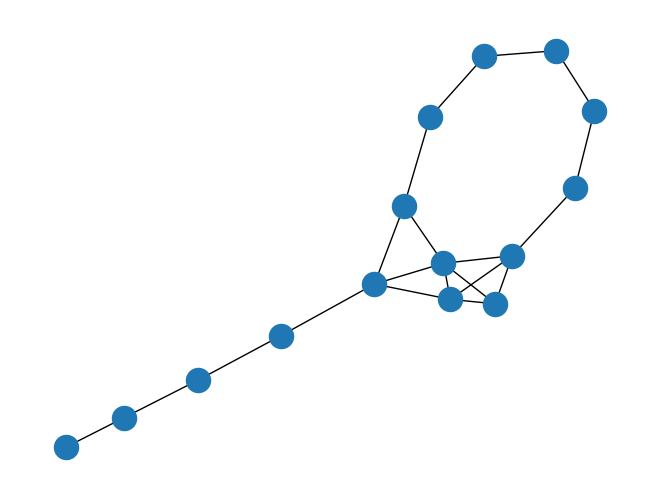

NodeView(('A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18'))

In [15]:
sample_graph = pbd_to_graph(
    PUZZLES_DIR / "pz01" / "1_solution_0_rpr_A_3_G.pdb",
    PUZZLES_DIR / "pz01" / "1_solution_0_rpr_A_3_G.tor",
)

nx.draw(sample_graph)
plt.show()
sample_graph.nodes

In [16]:
pdb_files = scores_df["pdb_path"]
pdb_files.shape

(34114,)

In [17]:
tor_files = scores_df["tor_path"]
tor_files.shape

(34114,)

In [18]:
labels = scores_df["score"]
labels.shape

(34114,)

In [ ]:
MAX_FEATURES = 427

X_list = []
y_list = []

for pdb, tor, label in zip(pdb_files, tor_files, labels):
    try:
        graph = pbd_to_graph(
            Path(pdb),
            Path(tor),
        )
        x_tmp = from_networkx(graph).x.flatten().numpy()
        x = np.zeros(MAX_FEATURES)
        x[: x_tmp.shape[0]] = x_tmp
        X_list.append(x)
        y_list.append(label)
    except:
        print(f"Error in file {tor}")
len(X_list)

In [20]:
X = np.array(X_list)
X.shape

(33422, 427)

In [21]:
y = np.array(y_list).astype(float)
y.shape

(33422,)

### RandomForest and CatBoost

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=23, test_size=0.3
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=23, test_size=0.3
)

In [23]:
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_valid.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 16376
Validation samples: 7019
Test samples: 10027


In [24]:
def root_mean_squared_error(y_true: np.array, y_pred: np.array) -> float:
    return pow(mean_squared_error(y_true, y_pred), 0.5)

In [ ]:
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(X_train, y_train)

In [30]:
y_pred_dummy = model_dummy.predict(X_test)
score_dummy = root_mean_squared_error(y_test, y_pred_dummy)
print(f"RMSE for {model_dummy.__class__.__name__} score_rf: {score_dummy}")

RMSE for DummyRegressor score_rf: 6.631089524737216


In [ ]:
model_rf = RandomForestRegressor(random_state=23)
model_rf.fit(X_train, y_train)

In [26]:
y_pred_rf = model_rf.predict(X_test)
score_rf = root_mean_squared_error(y_test, y_pred_rf)
print(f"RMSE for {model_rf.__class__.__name__} score_rf: {score_rf}")

RMSE for RandomForestRegressor score_rf: 4.78605683815697


In [ ]:
model_cb = CatBoostRegressor(iterations=2000, eval_metric="RMSE", random_seed=23)
model_cb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

In [31]:
y_pred_cb = model_cb.predict(X_test)
score_cb = root_mean_squared_error(y_test, y_pred_cb)
print(f"RMSE for {model_cb.__class__.__name__} score_rf: {score_cb}")

RMSE for CatBoostRegressor score_rf: 4.276693490656471
